In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

# Import Data

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=['Date'], index_col='Date')
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<AxesSubplot:xlabel='Date'>

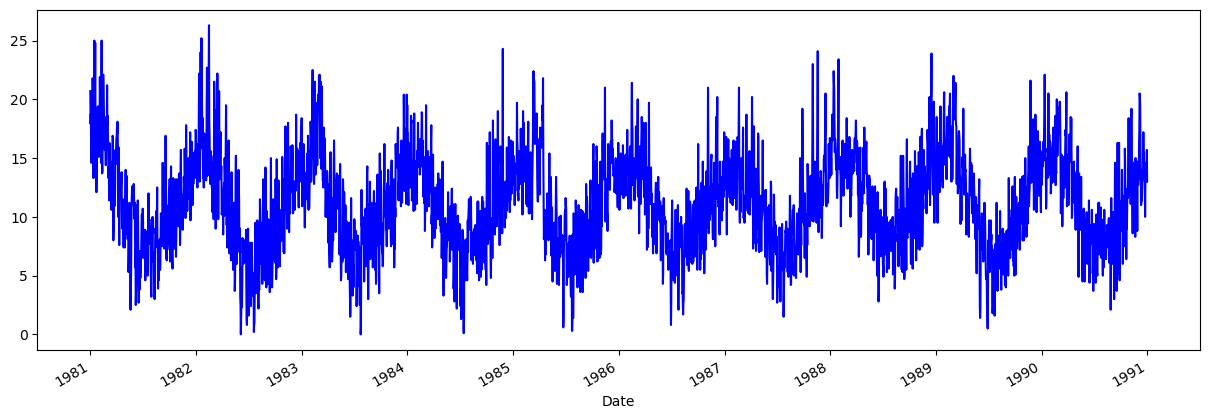

In [4]:
df.Temp.plot(figsize=(15, 5), color='b')

Note: data harian banyak noise nya karena jika memaka time yang lebih kecil contoh harian, menit, jam datanya jadi noisy sehingga jadi susah prediksinya. bisa saja tapi pakai rnn tapi lebih baik time yang lebih besar mingguan, bulanan

In [5]:
df = df.resample("W").mean()

<AxesSubplot:xlabel='Date'>

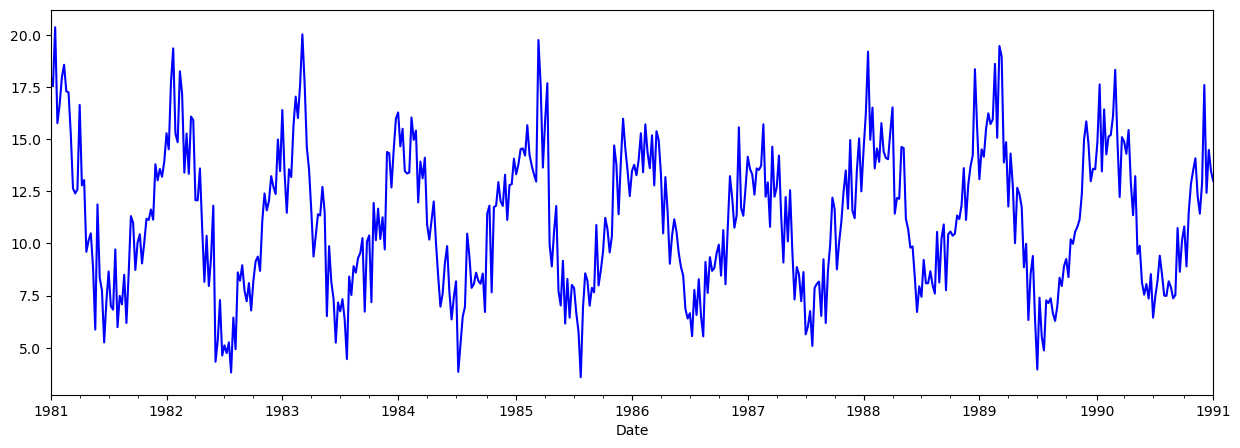

In [6]:
df.Temp.plot(figsize=(15, 5), color='b')

Jika pakai data lebih besar maka lakukan resampling

# Dataset Splitting

Dataset time series jangan di shuffle 

In [7]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

# Dataset & Data loader

Note:
* kalau pakai data multilabel pakai multilabeldataset
* kalau multi class pakai image class
* kalau tabular kita pakai tensor dataset
* kalau timeseries di jcopdl pakai timeseriesDataset

In [8]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

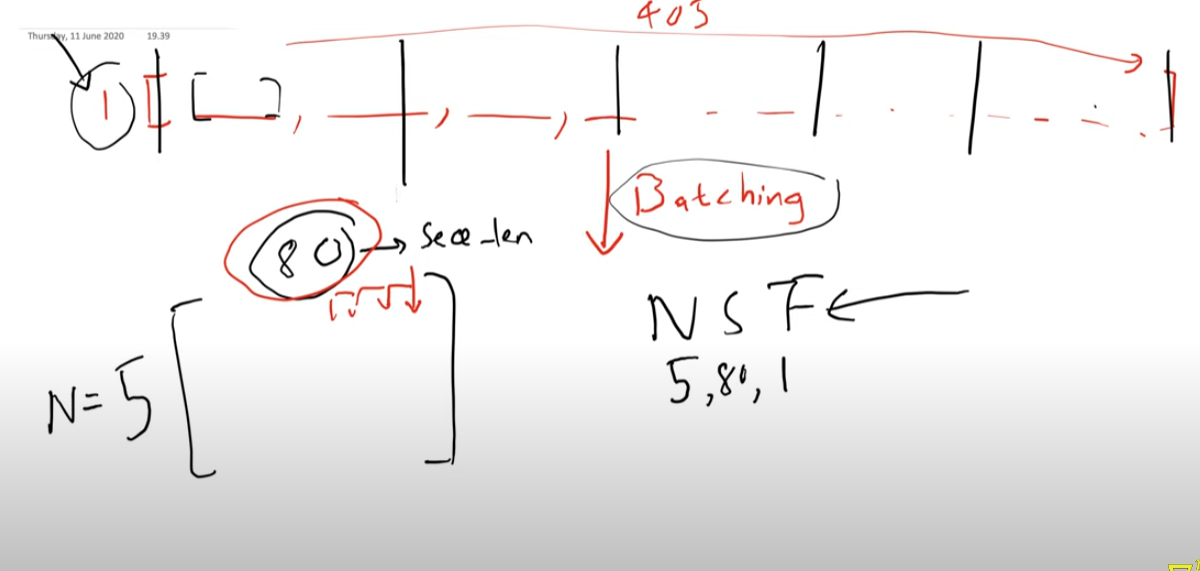

In [9]:
# seq_len = 6 # 6 minggu
# seq_len = 16 #16 minggu = 4 bulan
seq_len = 14 # artinya Backpropagation Throught Time sampai 14 hari ke belakang
# bs = 16
bs = 8

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=False)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs, shuffle=False)

(N, S, F): (29, 14, 1)
Note: last 11 data excluded

(N, S, F): (7, 14, 1)
Note: last 6 data excluded



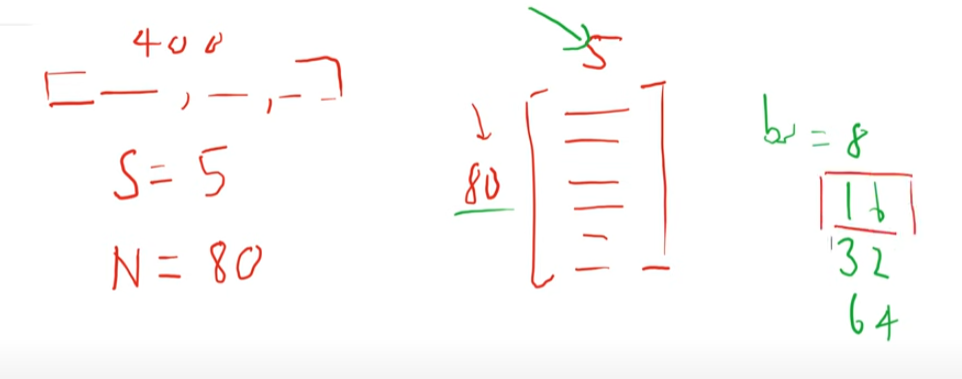

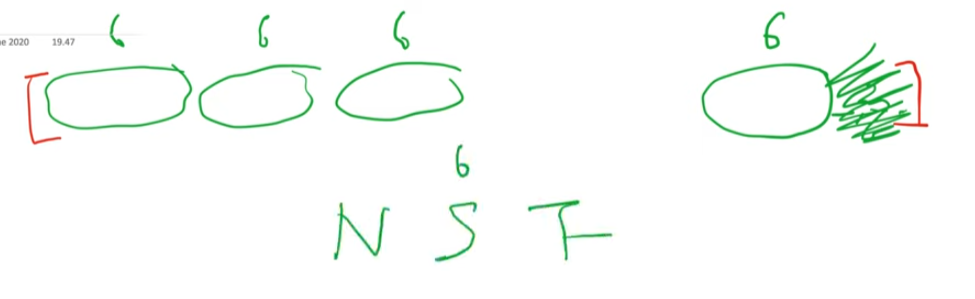

excluded maksudnya data dibuang atau diabaikan

# Arsitektur & Config

In [10]:
from jcopdl.layers import linear_block

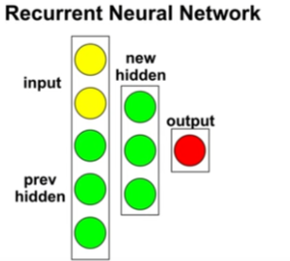

* layer pertama dan kedua itu sudah dibungkus oleh Pytorch next nya tinggal kombinasi linear ke output

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size ,output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.lstm(x, hidden)
        x = self.fc(x)
        return x, hidden

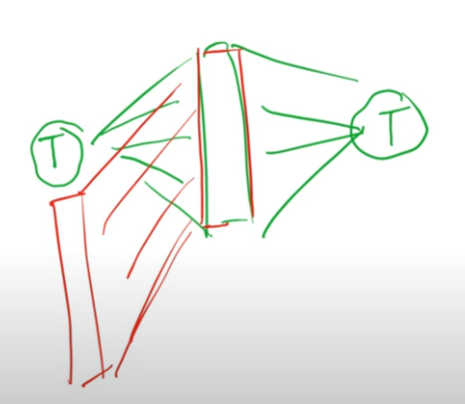

In [12]:
train_set.n_feature

1

In [24]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1,
    "hidden_size": 128,
    "num_layers": 3, 
    "dropout": 0,
    "seq_len": train_set.n_seq
})

# Training Preparation -> MCOC

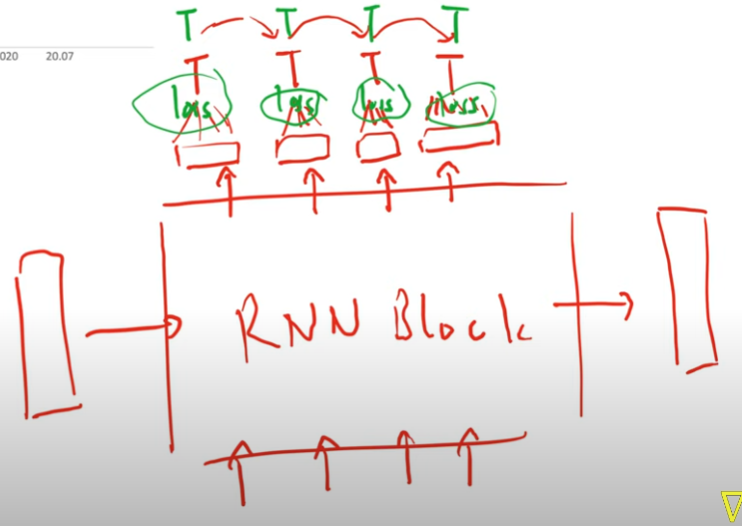

In [25]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/lstm")

# Training

In [26]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 129.4613 | Test_cost  = 129.9979 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 116.8879 | Test_cost  = 104.7628 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 88.7445 | Test_cost  = 75.3863 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 63.8339 | Test_cost  = 55.3119 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 47.1690 | Test_cost  = 42.2947 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 36.5416 | Test_cost  = 34.0554 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 29.6703 | Test_cost  = 28.4288 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 24.8547 | Test_cost  = 24.2576 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 21.2823 | Test_cost  = 21.1095 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 18.6285 | Test_cost  = 18.7695 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 16.6982 | Test_cost  = 17.0677 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 15.3358 | Test_cost  = 15.8690 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 14.4100 | Test_cost  = 15.0522 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 13.8039 | Test_cost  = 14.5112 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 13.4175 | Test_cost  = 14.1590 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 13.1714 | Test_cost  = 13.9285 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 13.0077 | Test_cost  = 13.7731 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 12.8886 | Test_cost  = 13.6629 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 12.7922 | Test_cost  = 13.5804 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 12.7081 | Test_cost  = 13.5168 | 


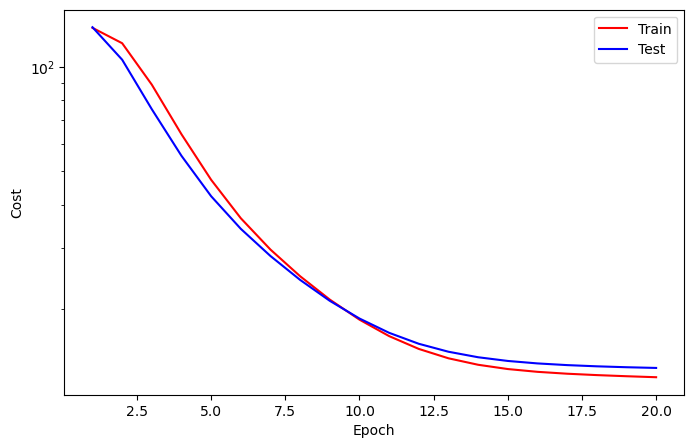

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 12.6326 | Test_cost  = 13.4672 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 12.5652 | Test_cost  = 13.4293 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 12.5063 | Test_cost  = 13.4006 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 12.4560 | Test_cost  = 13.3792 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 12.4136 | Test_cost  = 13.3626 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 12.3781 | Test_cost  = 13.3487 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 12.3479 | Test_cost  = 13.3360 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 12.3217 | Test_cost  = 13.3231 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 12.2984 | Test_cost  = 13.3097 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 12.2772 | Test_cost  = 13.2957 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 12.2576 | Test_cost  = 13.2813 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 12.2392 | Test_cost  = 13.2670 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 12.2218 | Test_cost  = 13.2530 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 12.2054 | Test_cost  = 13.2395 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 12.1900 | Test_cost  = 13.2266 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 12.1753 | Test_cost  = 13.2144 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 12.1614 | Test_cost  = 13.2030 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 12.1481 | Test_cost  = 13.1923 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 12.1353 | Test_cost  = 13.1823 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 12.1230 | Test_cost  = 13.1731 | 


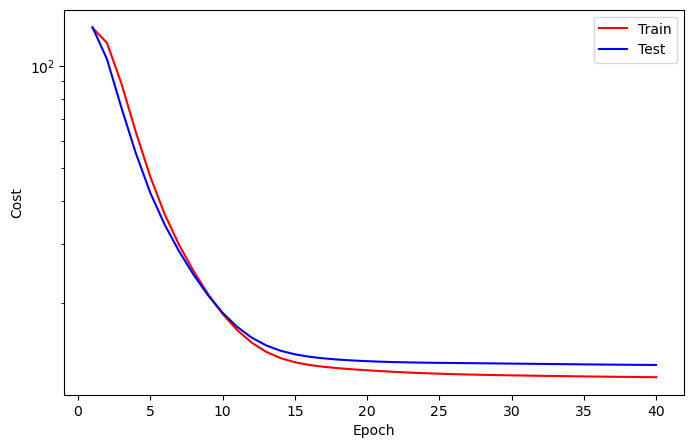

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 12.1111 | Test_cost  = 13.1649 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 12.0997 | Test_cost  = 13.1575 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 12.0887 | Test_cost  = 13.1503 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 12.0782 | Test_cost  = 13.1434 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 12.0680 | Test_cost  = 13.1367 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 12.0581 | Test_cost  = 13.1303 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 12.0485 | Test_cost  = 13.1241 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 12.0392 | Test_cost  = 13.1181 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 12.0302 | Test_cost  = 13.1122 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 12.0214 | Test_cost  = 13.1064 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 12.0128 | Test_cost  = 13.1008 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 12.0045 | Test_cost  = 13.0953 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 11.9964 | Test_cost  = 13.0900 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 11.9885 | Test_cost  = 13.0849 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 11.9807 | Test_cost  = 13.0800 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 11.9731 | Test_cost  = 13.0751 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 11.9657 | Test_cost  = 13.0703 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 11.9583 | Test_cost  = 13.0655 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 11.9509 | Test_cost  = 13.0606 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 11.9434 | Test_cost  = 13.0559 | 


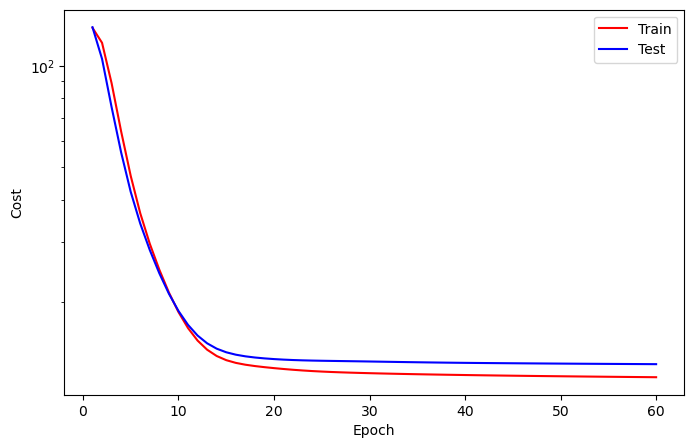

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 11.9362 | Test_cost  = 13.0513 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 11.9289 | Test_cost  = 13.0463 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 11.9213 | Test_cost  = 13.0414 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 11.9145 | Test_cost  = 13.0364 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 11.9076 | Test_cost  = 13.0318 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 11.9005 | Test_cost  = 13.0271 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 11.8937 | Test_cost  = 13.0218 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 11.8866 | Test_cost  = 13.0155 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 11.8793 | Test_cost  = 13.0078 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 11.8716 | Test_cost  = 12.9986 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 11.8629 | Test_cost  = 12.9863 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 11.8533 | Test_cost  = 12.9669 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 11.8415 | Test_cost  = 12.9472 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 11.8243 | Test_cost  = 12.9138 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 11.8036 | Test_cost  = 12.8683 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 11.7699 | Test_cost  = 12.7874 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 11.7283 | Test_cost  = 12.7486 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 11.6710 | Test_cost  = 12.6305 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 11.6064 | Test_cost  = 12.6054 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 11.5609 | Test_cost  = 12.4769 | 


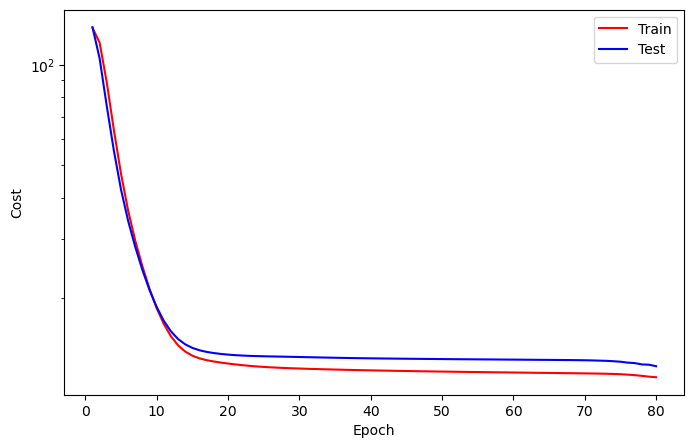

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 11.4652 | Test_cost  = 12.4495 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 11.4472 | Test_cost  = 12.3510 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 11.3314 | Test_cost  = 12.2535 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 11.3013 | Test_cost  = 12.2161 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 11.2110 | Test_cost  = 12.0947 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 11.1406 | Test_cost  = 12.0326 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 11.0749 | Test_cost  = 11.9040 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 10.9657 | Test_cost  = 11.8066 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 10.9247 | Test_cost  = 11.7504 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 10.8185 | Test_cost  = 11.6510 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 10.8119 | Test_cost  = 11.5701 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 10.6897 | Test_cost  = 11.4981 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 10.6199 | Test_cost  = 11.4313 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 10.5798 | Test_cost  = 11.3263 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 10.4693 | Test_cost  = 11.2665 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 10.4290 | Test_cost  = 11.1917 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 10.3575 | Test_cost  = 11.1106 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 10.2815 | Test_cost  = 11.0481 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 10.2255 | Test_cost  = 10.9764 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 10.1627 | Test_cost  = 10.9065 | 


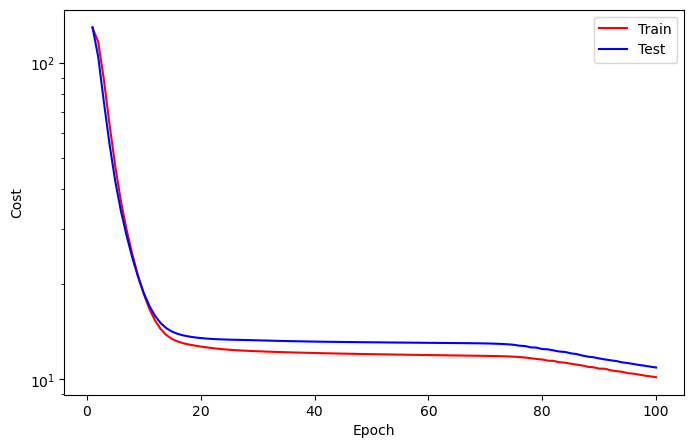

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 10.0940 | Test_cost  = 10.8402 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 10.0338 | Test_cost  = 10.7731 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 9.9680 | Test_cost  = 10.7071 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 9.9067 | Test_cost  = 10.6416 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 9.8438 | Test_cost  = 10.5717 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 9.7717 | Test_cost  = 10.4993 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 9.6952 | Test_cost  = 10.4205 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 9.6275 | Test_cost  = 10.3470 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 9.5507 | Test_cost  = 10.2481 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 9.4667 | Test_cost  = 10.2090 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 9.3948 | Test_cost  = 10.1169 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 9.3481 | Test_cost  = 10.0883 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 9.2902 | Test_cost  = 10.0062 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 9.2300 | Test_cost  = 9.9790 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 9.1680 | Test_cost  = 9.9159 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 9.1379 | Test_cost  = 9.8740 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 9.0835 | Test_cost  = 9.8104 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 9.0355 | Test_cost  = 9.7884 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 8.9804 | Test_cost  = 9.7038 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 8.9355 | Test_cost  = 9.6815 | 


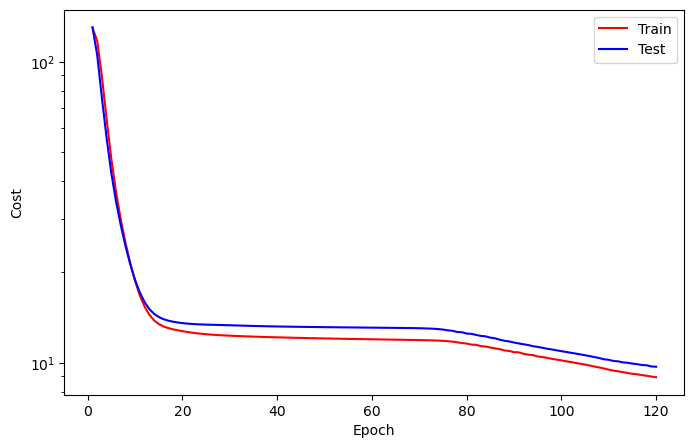

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 8.8858 | Test_cost  = 9.6136 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 8.8354 | Test_cost  = 9.5411 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 8.7907 | Test_cost  = 9.4897 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 8.7484 | Test_cost  = 9.4443 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 8.6973 | Test_cost  = 9.3714 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 8.6507 | Test_cost  = 9.2779 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 8.6039 | Test_cost  = 9.2734 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 8.5596 | Test_cost  = 9.1944 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 8.5188 | Test_cost  = 9.1834 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 8.4798 | Test_cost  = 9.0975 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 8.4351 | Test_cost  = 9.1438 | 
==> EarlyStop patience =  1 | Best test_cost: 9.0975


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 8.4220 | Test_cost  = 9.1175 | 
==> EarlyStop patience =  2 | Best test_cost: 9.0975


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 8.4084 | Test_cost  = 9.0309 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 8.4106 | Test_cost  = 9.0742 | 
==> EarlyStop patience =  1 | Best test_cost: 9.0309


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 8.5146 | Test_cost  = 9.1231 | 
==> EarlyStop patience =  2 | Best test_cost: 9.0309


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 8.3749 | Test_cost  = 8.9709 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 8.3870 | Test_cost  = 9.0033 | 
==> EarlyStop patience =  1 | Best test_cost: 8.9709


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 8.2912 | Test_cost  = 8.8459 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 8.2258 | Test_cost  = 8.8304 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 8.2585 | Test_cost  = 8.8843 | 


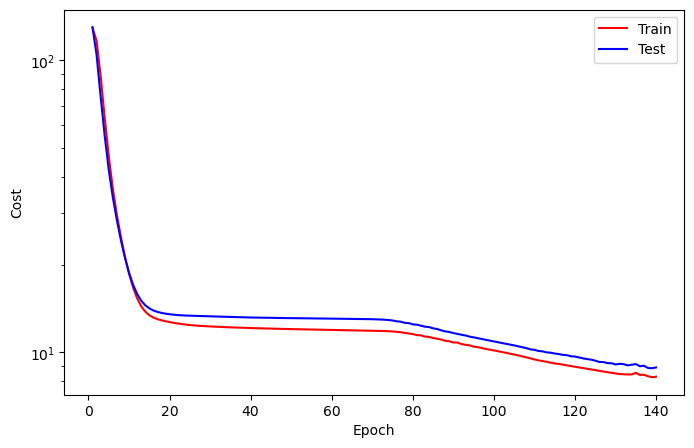

==> EarlyStop patience =  1 | Best test_cost: 8.8304


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 8.1924 | Test_cost  = 8.8105 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 8.1434 | Test_cost  = 8.6719 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 8.1095 | Test_cost  = 8.7129 | 
==> EarlyStop patience =  1 | Best test_cost: 8.6719


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 8.0406 | Test_cost  = 8.5490 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 7.9885 | Test_cost  = 8.5389 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 7.9270 | Test_cost  = 8.5479 | 
==> EarlyStop patience =  1 | Best test_cost: 8.5389


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 7.8961 | Test_cost  = 8.4853 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 7.8556 | Test_cost  = 8.4104 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 7.8292 | Test_cost  = 8.4397 | 
==> EarlyStop patience =  1 | Best test_cost: 8.4104


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 7.7890 | Test_cost  = 8.3807 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 7.7515 | Test_cost  = 8.3060 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 7.7372 | Test_cost  = 8.3949 | 
==> EarlyStop patience =  1 | Best test_cost: 8.3060


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 7.7148 | Test_cost  = 8.3149 | 
==> EarlyStop patience =  2 | Best test_cost: 8.3060


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 7.7145 | Test_cost  = 8.2929 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 7.7049 | Test_cost  = 8.3765 | 
==> EarlyStop patience =  1 | Best test_cost: 8.2929


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 7.8616 | Test_cost  = 8.5111 | 
==> EarlyStop patience =  2 | Best test_cost: 8.2929


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 7.7943 | Test_cost  = 8.2121 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 7.7540 | Test_cost  = 8.3856 | 
==> EarlyStop patience =  1 | Best test_cost: 8.2121


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 7.7926 | Test_cost  = 8.2194 | 
==> EarlyStop patience =  2 | Best test_cost: 8.2121


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 7.6228 | Test_cost  = 8.2337 | 


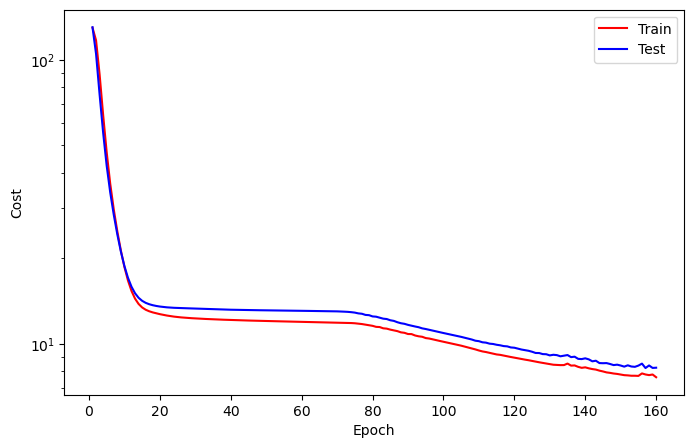

==> EarlyStop patience =  3 | Best test_cost: 8.2121


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 7.6243 | Test_cost  = 8.1475 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 7.6436 | Test_cost  = 8.0802 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 7.4926 | Test_cost  = 8.0038 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 7.4406 | Test_cost  = 7.9432 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 7.4343 | Test_cost  = 7.9423 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 7.3613 | Test_cost  = 7.8558 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 7.3338 | Test_cost  = 7.8466 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 7.2817 | Test_cost  = 7.8328 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 7.2525 | Test_cost  = 7.7287 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 7.2122 | Test_cost  = 7.7126 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 7.1683 | Test_cost  = 7.6949 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 7.1270 | Test_cost  = 7.5883 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 7.0528 | Test_cost  = 7.5070 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 6.9974 | Test_cost  = 7.5208 | 
==> EarlyStop patience =  1 | Best test_cost: 7.5070


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 6.9733 | Test_cost  = 7.4532 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 6.9448 | Test_cost  = 7.4000 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 6.8971 | Test_cost  = 7.3668 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 6.9251 | Test_cost  = 7.3925 | 
==> EarlyStop patience =  1 | Best test_cost: 7.3668


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 6.9691 | Test_cost  = 7.3435 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 6.9385 | Test_cost  = 7.4980 | 


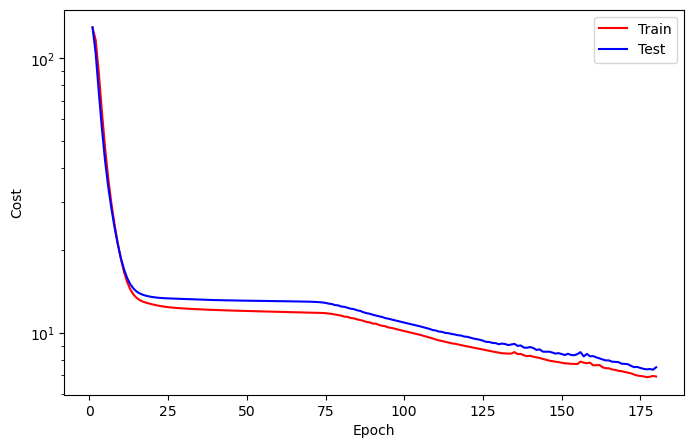

==> EarlyStop patience =  1 | Best test_cost: 7.3435


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 6.9308 | Test_cost  = 7.2941 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 6.8203 | Test_cost  = 7.1506 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 6.7684 | Test_cost  = 7.3779 | 
==> EarlyStop patience =  1 | Best test_cost: 7.1506


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 6.7389 | Test_cost  = 7.0649 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 6.6992 | Test_cost  = 7.0465 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 6.6879 | Test_cost  = 7.2979 | 
==> EarlyStop patience =  1 | Best test_cost: 7.0465


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 6.7002 | Test_cost  = 7.0623 | 
==> EarlyStop patience =  2 | Best test_cost: 7.0465


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 7.0407 | Test_cost  = 7.2020 | 
==> EarlyStop patience =  3 | Best test_cost: 7.0465


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 6.9875 | Test_cost  = 7.2066 | 
==> EarlyStop patience =  4 | Best test_cost: 7.0465


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 6.9773 | Test_cost  = 7.2581 | 
==> EarlyStop patience =  5 | Best test_cost: 7.0465
==> Execute Early Stopping at epoch: 190 | Best test_cost: 7.0465
==> Best model is saved at model/lstm


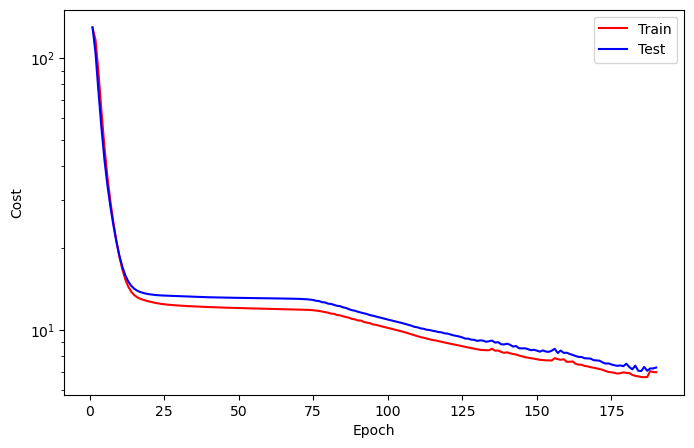

In [27]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Forecast

In [28]:
from luwiji.rnn import illustration

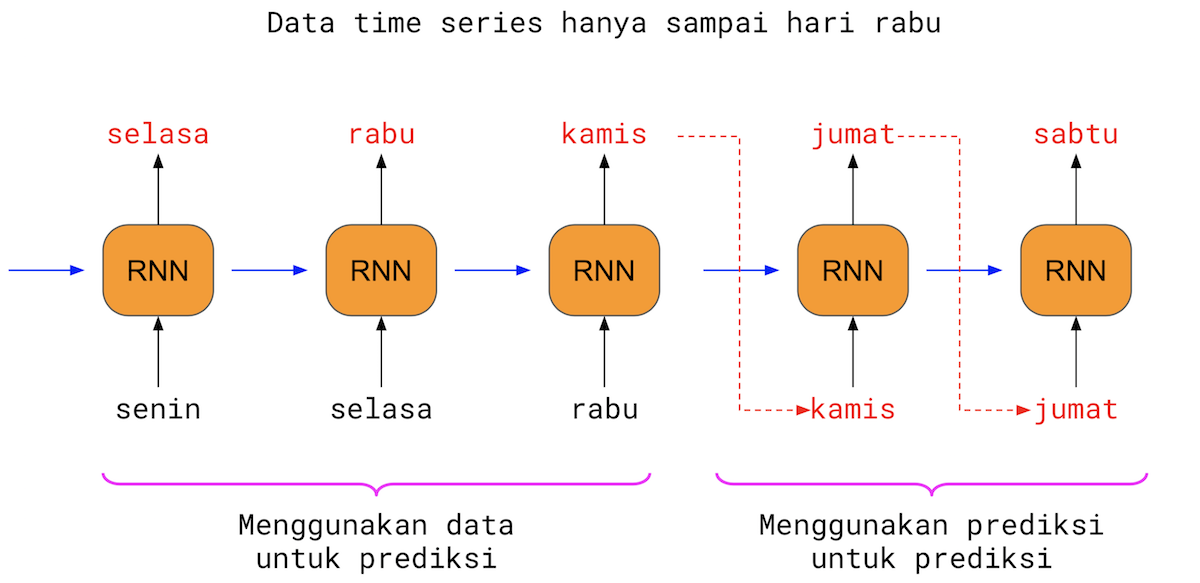

In [29]:
illustration.forecast

senin untuk prediksi hari selasa sebagai training,

selasa untuk prediksi hari rabu sebagai training,

rabu untuk prediksi hari kamis sebagai training,

kamis hasil prediksi digunakan untuk prediksi jumat dan seterusnya

yang kiri untuk training, yang kanan di pakai untuk prediksi masa depan

In [30]:
from utils import data4pred, pred4pred

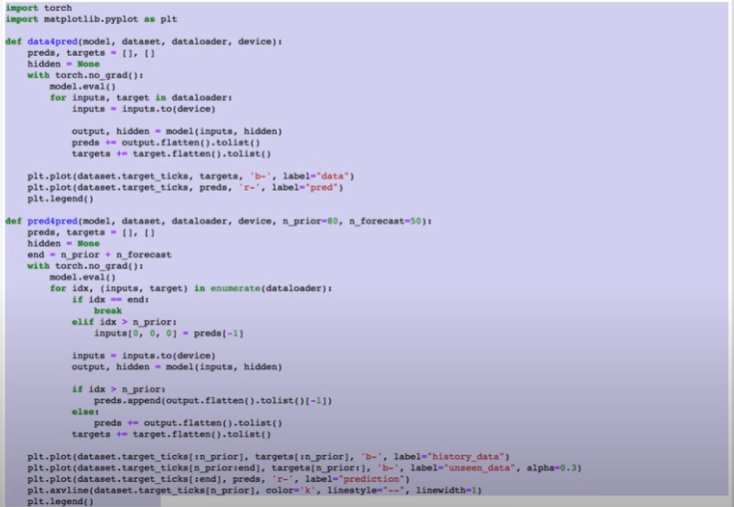

In [31]:
import torch
import matplotlib.pyplot as plt

def data4pred(model, dataset, dataloader, device):
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            
            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()
    
    plt.plot(dataset.target_ticks, targets, 'b-', label='data')
    plt.plot(dataset.target_ticks, preds, 'r-', label='pred')
    plt.legend()
    
def pred4pred(model, dataset, dataloader, device, n_prior=80, n_forecast=50):
    preds, targets = [], []
    hidden = None
    end = n_prior + n_forecast
    with torch.no_grad():
        model.eval()
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
            
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()
            targets += target.flatten().tolist()
            
    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label='unseen_data', alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, "r-", label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle='--', linewidth=1)
    plt.legend()

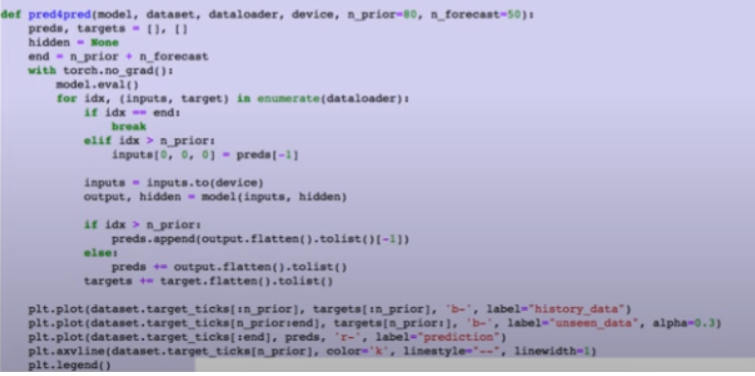

In [32]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



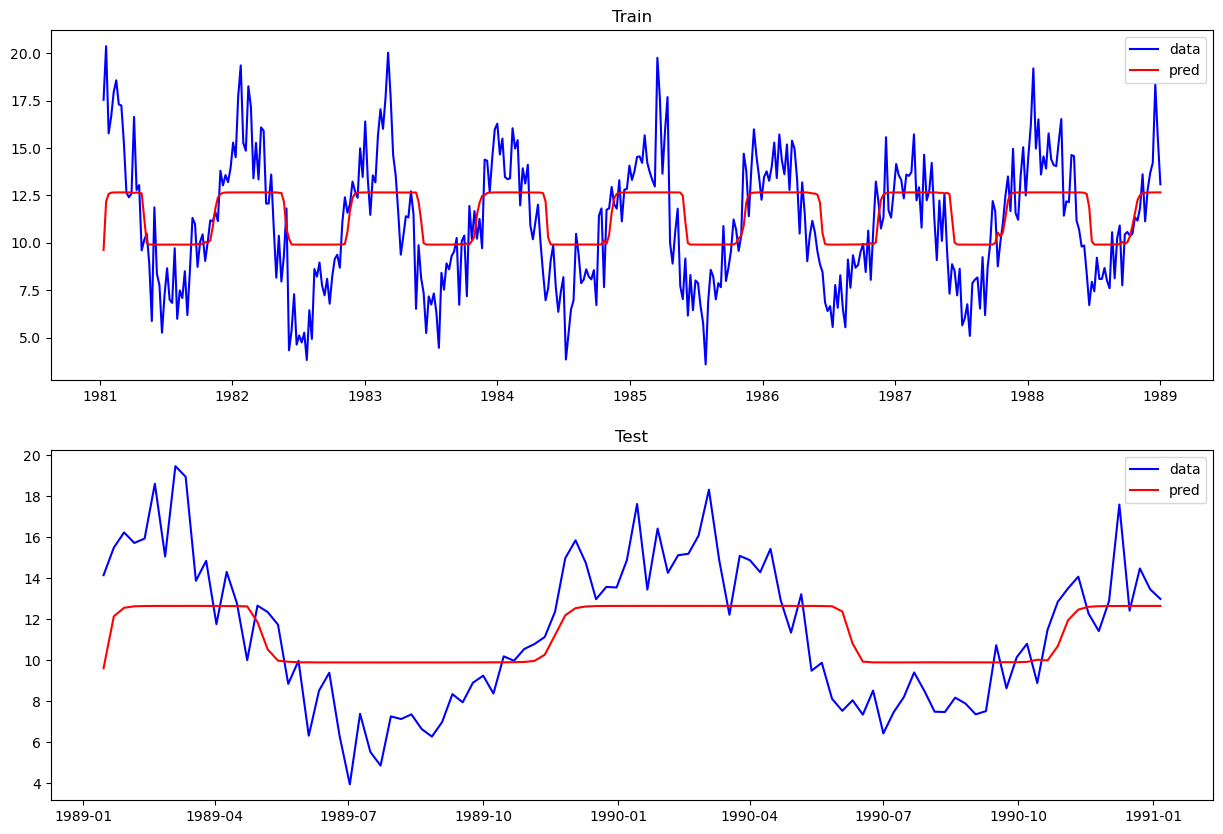

In [33]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test");

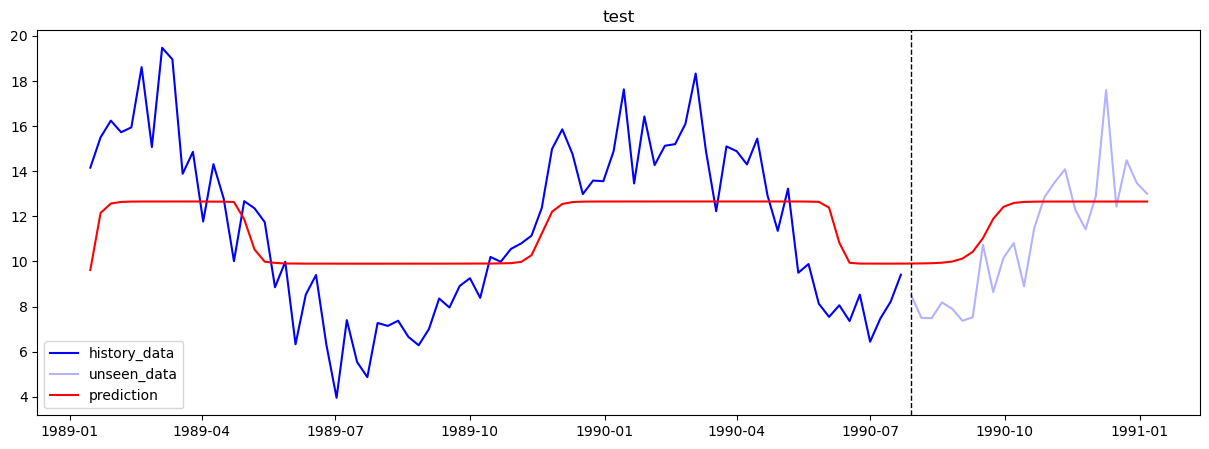

In [34]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test");

note:

di time series forecasting by default itu overfit, kita harus expect prediksi kita salah. ketika data baru prediksi kita meleset

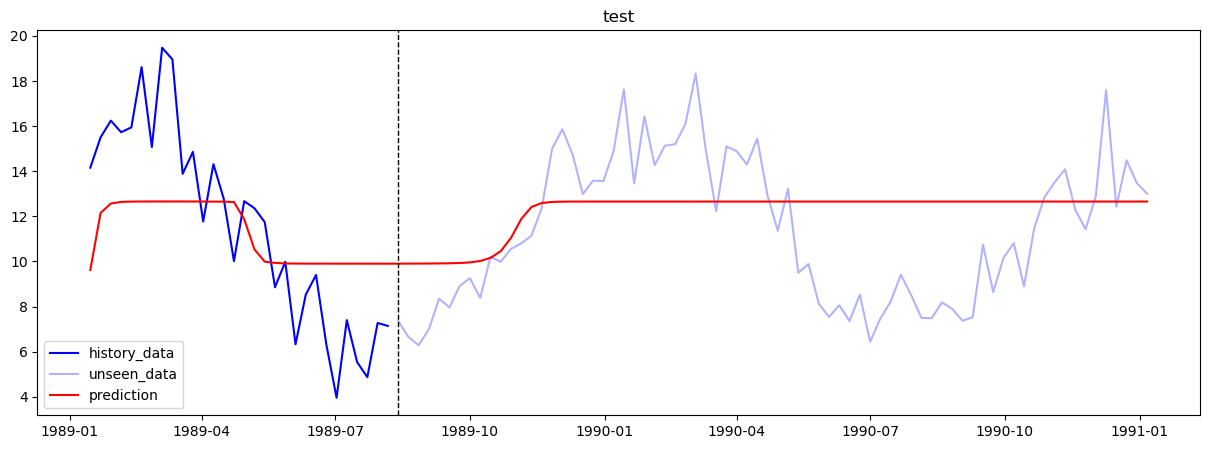

In [35]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=30, n_forecast=110)
plt.title("test");